<div style="display:flex;flex-direction:column;align-items:center;justify-content:center;padding:22px 0 8px;background:linear-gradient(180deg,rgba(103, 57, 228, 1),transparent);">
  <h1 style="margin:0;font-family:'Segoe UI', Roboto, Helvetica, Arial, sans-serif;color:#e8eced;font-size:40px;letter-spacing:-0.5px;"><b>LLM Benchmark & Evaluation</b></h1>
  <p style="margin:8px 0 0;color:#e8eced;font-size:15px;max-width:900px;text-align:center;">Exploring benchmarks, evaluation metrics, and insights to measure and compare large language models effectively.</p>
  <div style="margin-top:12px;display:flex;gap:8px;flex-wrap:wrap;justify-content:center;">
    <span style="background:#eef2ff;color:#3730a3;padding:6px 12px;border-radius:999px;font-size:12px;font-weight:600;">Benchmarking</span>
    <span style="background:#ecfeff;color:#045e66;padding:6px 12px;border-radius:999px;font-size:12px;font-weight:600;">Metrics</span>
    <span style="background:#fff7ed;color:#92400e;padding:6px 12px;border-radius:999px;font-size:12px;font-weight:600;">Evaluation</span>
  </div>
</div>

<style>
  .notebook-title-decor {height:8px;background:linear-gradient(90deg,#7c3aed,#06b6d4);border-radius:6px;margin:16px 0 22px;max-width:720px;margin-left:auto;margin-right:auto}
</style>
<div class="notebook-title-decor"></div>

##  [&#9650;](#toc0_) <a id='toc1_1_'></a>**Introduction**

This notebook explores benchmarks and evaluation metrics for our Graph Rag model.
It provides an insight on: 

- Query examples
- accuracy metrics
- latency plots

Use the sections below to run experiments, visualize results, and capture insights.

**Table of contents**<a id='toc0_'></a>     
- [**Query Examples**](#toc2_)    
  - [Build a Session](#toc2_1_)    
  - [Ask Questions](#toc2_2_)    
- [**Benchmarks**](#toc3_)    
  - [Result](#toc3_1_)    
  - [Conclusion](#toc3_2_) 

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
#  [&#9650;](#toc0_) <a id='toc2_'></a>**Query Examples**

Let's do a small test on four PDF files:
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- [Attention Is Not All You Need Anymore](https://arxiv.org/abs/2308.07661)
- [Attention is not Explanation](https://arxiv.org/abs/1902.10186)
- [On the rheology of cats](https://www.drgoulu.com/wp-content/uploads/2017/09/Rheology-of-cats.pdf)

The pipeline use below is the pipeline reproduced in the app.
For more information on it check `README.md`.

In [1]:
from requests import request
from src.graph_rag.config import settings

Check the settings:

In [2]:
attribute =  [
    "data_dir", 
    "ollama_base_url", "ollama_chat_model", "ollama_extraction_model", "ollama_embedding_model", 
    "chroma_db_dir", 
    "max_sources_per_use_case", "min_relevance_score", "source_preview_chars", "usecase_graph_dir", "usecase_vector_prefix", 
    "max_neighbors_per_entity", "graph_store_path", 
    "extraction_max_concurrency", "extraction_batch_size", "extraction_debug_samples", "max_graph_paths_per_answer"]

print("Current Settings:")
print("-----------------")
for setting in attribute:
    print(f"{setting:<30}: {getattr(settings, setting)}")

Current Settings:
-----------------
data_dir                      : data\raw
ollama_base_url               : http://localhost:11434
ollama_chat_model             : llama3
ollama_extraction_model       : llama3
ollama_embedding_model        : nomic-embed-text
chroma_db_dir                 : chroma_db
max_sources_per_use_case      : 12
min_relevance_score           : 0.1
source_preview_chars          : 1500
usecase_graph_dir             : graph_sessions
usecase_vector_prefix         : graphrag_usecase_
max_neighbors_per_entity      : 10
graph_store_path              : graph_store.json
extraction_max_concurrency    : 8
extraction_batch_size         : 8
extraction_debug_samples      : 0
max_graph_paths_per_answer    : 5


##  [&#9650;](#toc0_) <a id='toc2_1_'></a>Build a Session

To build a session we can pass two parameters:
- `brief`: that will help the model to select the important source to avoid building a graph on all our data (which can be pretty long). It doesn't affect the knowledge graph itself.
- `max_sources`: which is the number of source the model will kept

Let's first pass on all our data, thus the brief doesn't matter.

In [3]:
headers = {"Content-Type": "application/json"}
payload = {
    'brief': 'A knowledge graph on all our data',
    'max_sources': 4,
}
r = request("POST", f"http://localhost:8000/use_case/build", headers=headers, json=payload).json()
r

{'session_id': 'b6cd94d1-a57d-4e9b-bef4-bdf6e5a0ad05',
 'brief': 'A knowledge graph on all our data',
 'num_sources': 4,
 'num_chunks': 77,
 'selected_sources': [{'path': 'data\\raw\\Attention_is_all_you_need.pdf',
   'score': 0.3125573410612118,
   'overlap': 0.0,
   'embedding_score': 0.5209289017686863,
   'preview': 'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nG'},
  {'path': 'data\\raw\\Attention_is_not_all_you_need_anymore.pdf',
   'score': 0.27924743334935953,
   'overlap': 0.0,
   'embedding_score': 0.4654123889155993,
   'preview': 'Attention Is Not All You Need Anymore\nZhe Chen\nSchool of Computer Science and 

As we can see, these results are expected given the generic brief *'A knowledge graph on all our data'*.

- `Embedding score`: semantic similarity between the brief and each document (values ~0.41–0.52 here).
- `Overlap`: lexical overlap is 0.0 because the brief is very generic, and the preview texts do not share the same long tokens (>3 chars) after the simple token filter. So no keyword matches were found.
- `Selection score`: calculated as $0.6 * \textrm{embedding score} + 0.4 * \textrm{overlap}$. With overlap=0, the final score is $\approx 0.6 * \textrm{embedding score}$.

##  [&#9650;](#toc0_) <a id='toc2_2_'></a>Ask Questions

In [7]:
payload = {
    'session_id': r.get('session_id'),
    'question': "What is Attention, and when should it be used?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
answ

{'answer': 'Based on the provided graph context, it appears that you are asking about attention and when to use it. Attention is a mechanism used in deep learning models, particularly in natural language processing (NLP) tasks, such as machine translation, question answering, and text summarization.\n\nAttention allows the model to focus on specific parts of the input data that are relevant for making predictions or generating outputs. In other words, attention helps the model to selectively attend to certain tokens, words, or phrases in a sequence, rather than considering all of them equally.\n\nThere are different types of attention mechanisms, including:\n\n1. **Self-Attention**: This type of attention is used within a single sequence (e.g., a sentence) to focus on specific parts of the input.\n2. **Cross-Attention**: This type of attention is used between two sequences (e.g., a source and target language) to align relevant information.\n\nWhen to use attention:\n\n1. **Sequence-to-

In [8]:
print(answ["answer"])

Based on the provided graph context, it appears that you are asking about attention and when to use it. Attention is a mechanism used in deep learning models, particularly in natural language processing (NLP) tasks, such as machine translation, question answering, and text summarization.

Attention allows the model to focus on specific parts of the input data that are relevant for making predictions or generating outputs. In other words, attention helps the model to selectively attend to certain tokens, words, or phrases in a sequence, rather than considering all of them equally.

There are different types of attention mechanisms, including:

1. **Self-Attention**: This type of attention is used within a single sequence (e.g., a sentence) to focus on specific parts of the input.
2. **Cross-Attention**: This type of attention is used between two sequences (e.g., a source and target language) to align relevant information.

When to use attention:

1. **Sequence-to-sequence tasks**: Atten

In [9]:
print(list(set([s["source"] for s in answ["citations"]])))

['data\\raw\\Attention_is_not_explanation.pdf', 'data\\raw\\Attention_is_not_all_you_need_anymore.pdf', 'data\\raw\\Attention_is_all_you_need.pdf']


We have a really good answer based on the right data! And as we can see our model didn't use *On the rheology of cat* to answer which is a good thing.

In [23]:
from pyvis.network import Network
from IPython.display import IFrame, display

# Extract graph data from the answer (safe access)
graph_data = answ.get("graph_context") if isinstance(answ, dict) else None
if not graph_data:
    raise ValueError("No graph_context found in response")

nodes = graph_data.get("nodes", [])
edges = graph_data.get("edges", [])

net = Network(notebook=True, cdn_resources='remote')

# Add nodes
for node in nodes:
    nid = node.get("id")
    label = node.get("name") or node.get("id")
    title = str(node.get("properties", "") or node.get("description", ""))
    net.add_node(nid, label=label, title=title)

# Add edges
for edge in edges:
    src = edge.get("source")
    tgt = edge.get("target")
    lbl = edge.get("type") or edge.get("relationship", "")
    net.add_edge(src, tgt, label=lbl)

# Generate HTML and write using UTF-8 to avoid Windows cp1252 errors
html = net.generate_html()
with open("graph.html", "w", encoding="utf-8") as f:
    f.write(html)

# Display interactive graph in the notebook
display(IFrame("graph.html", width=900, height=600))

In [24]:
payload = {
    'session_id': r.get('session_id'),
    'question': "Can cat considered liquid?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
answ

{'answer': 'What a delightful and absurd paper!\n\nWhile cats are not typically considered liquids, the author of this paper takes a humorous approach to exploring the rheological properties of Felis catus (the domestic cat). The text is filled with witty remarks, clever analogies, and playful references to scientific concepts.\n\nIn the context of graph theory, I\'d say that the nodes in this graph represent different ideas, concepts, or themes related to the rheology of cats. The edges connecting these nodes could represent relationships between these ideas, such as "cats are liquids" → "surface tension" → "yield stress".\n\nSome notable nodes in this graph include:\n\n1. "Cats are liquids": This node represents the central claim of the paper, which is that cats can be considered liquids in certain contexts.\n2. "Surface tension": This node connects to the idea that cats have a surface tension similar to water droplets bouncing on hydrophobic substrates.\n3. "Yield stress": This node

In [25]:
print(answ["answer"])

What a delightful and absurd paper!

While cats are not typically considered liquids, the author of this paper takes a humorous approach to exploring the rheological properties of Felis catus (the domestic cat). The text is filled with witty remarks, clever analogies, and playful references to scientific concepts.

In the context of graph theory, I'd say that the nodes in this graph represent different ideas, concepts, or themes related to the rheology of cats. The edges connecting these nodes could represent relationships between these ideas, such as "cats are liquids" → "surface tension" → "yield stress".

Some notable nodes in this graph include:

1. "Cats are liquids": This node represents the central claim of the paper, which is that cats can be considered liquids in certain contexts.
2. "Surface tension": This node connects to the idea that cats have a surface tension similar to water droplets bouncing on hydrophobic substrates.
3. "Yield stress": This node relates to the concept

In [27]:
print(list(set([s["source"] for s in answ["citations"]])))

['data\\raw\\Rheology-of-cats.pdf']


The answer is not best but is still good.<br>
The problem is that the model is too conscious that it is given a graph and needs to work with this graph.

Otherwise, we get a pretty clean and clear answer on the different notion and properties of the cat than can make them look like liquid.

Let's test our model selection by reducing the number of sources with a specific brief to see if it manages to take the three good answer.

In [28]:
headers = {"Content-Type": "application/json"}
payload = {
    'brief': 'Information on Attention in the litterature',
    'max_sources': 3,
}
r = request("POST", f"http://localhost:8000/use_case/build", headers=headers, json=payload).json()
r

{'session_id': '7348c416-e078-447a-ae57-e8afb452549d',
 'brief': 'Information on Attention in the litterature',
 'num_sources': 3,
 'num_chunks': 69,
 'selected_sources': [{'path': 'data\\raw\\Attention_is_not_all_you_need_anymore.pdf',
   'score': 0.4152653122695793,
   'overlap': 0.3333333333333333,
   'embedding_score': 0.4698866315604099,
   'preview': 'Attention Is Not All You Need Anymore\nZhe Chen\nSchool of Computer Science and Engineering\nNortheastern University\nShenyang, Liaoning, China\nml_iot@163.com; chenzhe@mail.neu.edu.cn\nAbstract\nIn recent years, the popular Transformer architecture has achieved great success in many application\nareas, including natural language processing and computer vision. Many existing works aim to reduce\nthe comput'},
  {'path': 'data\\raw\\Attention_is_all_you_need.pdf',
   'score': 0.41107620874538064,
   'overlap': 0.3333333333333333,
   'embedding_score': 0.4629047923534122,
   'preview': 'Provided proper attribution is provided, Google 

Indeed we don't get the paper on cats, and only got the ones related to attention.

In [31]:
payload = {
    'session_id': r.get('session_id'),
    'question': "Can cat considered liquid?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
print(answ["answer"])

No, cats cannot be considered liquids. Cats are living creatures that belong to the class Mammalia and order Carnivora. They have a solid body made up of bones, muscles, organs, and skin, which is very different from the physical properties of liquids.

In physics, a liquid is defined as a state of matter characterized by a fixed volume but no fixed shape, where particles are close together but still able to flow freely. Liquids have certain properties such as viscosity, surface tension, and density that distinguish them from solids and gases.

Cats, on the other hand, do not possess these properties. They are solid objects with a specific shape and volume, and their physical behavior is governed by different laws than those of liquids. So, it's not possible to consider cats as liquids.


Our model answer completely differs from the previous one.

However, the answer that we would have preferred was that it doesn't know how to answer.<br>
This is also because the answer is too generic.

In [35]:
payload = {
    'session_id': r.get('session_id'),
    'question': "Can you tell me a little more about the game Clair Obscur: Expedition 33?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
print(answ["answer"])

I see you're interested in learning more about the game Clair Obscur: Expedition 33. Unfortunately, I have to inform you that there is no such game as Clair Obscur: Expedition 33.

The text you provided appears to be a collection of passages from various sources, including academic papers and online articles. The topics discussed include attention mechanisms in neural networks, feature importance measures, and transformer models.

If you're interested in learning more about these topics or exploring related research areas, I'd be happy to help you find relevant resources or provide an overview of the concepts. Just let me know!


That's the answer we expect !<br>
Even tho it doesn't seem to be really consistent.

#  [&#9650;](#toc0_) <a id='toc3_'></a>**Benchmarks**

We are going to use the [Ragas](https://docs.ragas.io/en/stable/getstarted/quickstart/)' framework which offer a good and simple way to test our model.

For the benchmark we chose to use [GraphRAG-Bench](https://github.com/GraphRAG-Bench/GraphRAG-Benchmark/tree/main#leaderboards) with four level of complexity: 
- **Level 1**: **Fact Retrieval** *Example: "Which region of France is Mont St. Michel located?"*
- **Level 2**: **Complex Reasoning** *Example: "How did Hinze's agreement with Felicia relate to the perception of England's rulers?"*
- **Level 3**: **Contextual Summarization** *Example: "What role does John Curgenven play as a Cornish boatman for visitors exploring this region?"*
- **Level 4**: **Creative Generation** *Example: "Retell King Arthur's comparison to John Curgenven as a newspaper article."*

It took about **199min 4.9s to index the entire dataset** (Novel + Medical).

Because it will take too long to go through all the question, we chose to only go through a sample of it. The sample is composed of 25% of the question chosen randomly.

It took **240 minutes** to go through the **entire sample** (735 questions) with an average taking on **average 19.6s**.

In [3]:
headers = {"Content-Type": "application/json"}
r = request("POST", f"http://localhost:8000/build_index", headers=headers).json()
r

{'num_sources': 21,
 'num_chunks': 2906,
 'sources': ['D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Medical.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10146.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10321.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10356.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10762.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-2544.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-25646.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-26183.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-29973.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-30752.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-40700.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-4128.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-41603.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-44557.txt',
  'D:\\VSCode_ws\\llm_genai_pr

You then just needs to run the `evals.py` file. The result will appear in the form of a .csv in the experiments folder.

In [4]:
r

{'num_sources': 21,
 'num_chunks': 2906,
 'sources': ['D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Medical.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10146.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10321.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10356.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10762.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-2544.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-25646.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-26183.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-29973.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-30752.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-40700.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-4128.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-41603.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-44557.txt',
  'D:\\VSCode_ws\\llm_genai_pr

In [7]:
import pandas as pd

df = pd.read_csv("rag_eval/evals/experiments/test_dataset_results.csv")

In [8]:
df.head()

,answer_relevancy,conciseness,coverage,evidence,evidence_triples,faithfulness,grading_notes,grounding,log_file,question,response
0,unknown,concise,unknown,Charles is the driver of the carriage.,"(driver,is,Charles)",unknown,Charles is the driver of the carriage.,unknown,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,"During the journey through Cornwall, who drove...","According to the text, it was Yuba Bill who dr..."
1,unknown,verbose,unknown,Henry de la Pomeroy caused himself to be bled ...,"(Henry de la Pomeroy,caused himself to be bled...",unknown,Henry de la Pomeroy,unknown,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,In the historical account relating to St. Mich...,I see you've got a bunch of text snippets from...
2,unknown,verbose,unknown,Asparagus Island is located near or within Kyn...,"(Kynance Cove,is located near,Asparagus Island...",unknown,"Asparagus Island, Gull Rock, and Bellows",unknown,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,In the account of the travelers' visit to Kyna...,The question asks about natural landmarks desc...
3,off-topic,concise,low,Mary Mundy admired the Professor.,"(Mary Mundy,admired,Professor)",unfaithful,Mary Mundy admired the Professor.,hallucinated,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,"During the visit to Mullion in the story, whom...",It looks like you have a collection of texts f...
4,unknown,concise,unknown,Mont St. Michel is located in Normandy.,"(Mont St. Michel,was in,Normandy)",unknown,Normandy,unknown,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,According to the narrative's discussion of his...,I see you've provided a large block of text! A...


##  [&#9650;](#toc0_) <a id='toc3_1_'></a>Result

Overall Evaluation Metrics Summary

COVERAGE:
  - unknown        :   87.5%
  - high           :    6.7%
  - low            :    5.6%
  - partial        :    0.3%

GROUNDING:
  - unknown        :   87.5%
  - grounded       :    6.8%
  - hallucinated   :    5.7%

FAITHFULNESS:
  - unknown        :   87.5%
  - faithful       :    6.7%
  - unfaithful     :    5.9%

ANSWER_RELEVANCY:
  - unknown        :   87.5%
  - on-topic       :    6.8%
  - off-topic      :    5.7%

CONCISENESS:
  - verbose        :   67.5%
  - concise        :   31.3%
  - terse          :    1.2%


C:\Users\Jules\AppData\Local\Temp\ipykernel_14208\2200834174.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


<Figure size 1200x800 with 0 Axes>

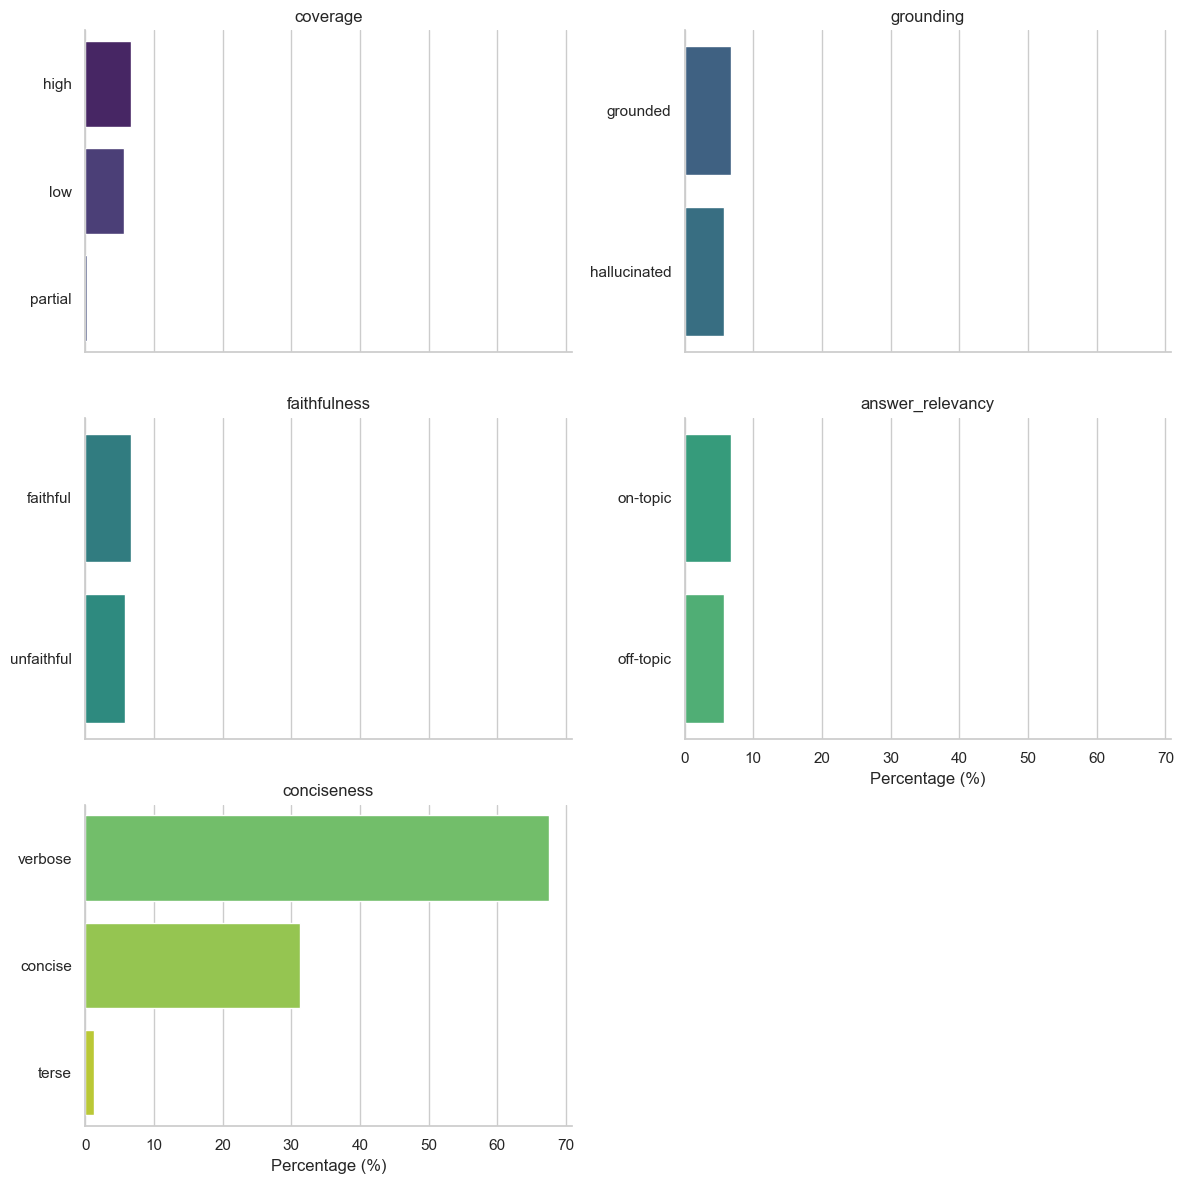

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results
df = pd.read_csv("rag_eval/evals/experiments/test_dataset_results.csv")

# Define the metrics we want to summarize
metrics = ["coverage", "grounding", "faithfulness", "answer_relevancy", "conciseness"]

print("Overall Evaluation Metrics Summary")
print("=" * 40)

summary_data = []

for metric in metrics:
    if metric in df.columns:
        counts = df[metric].value_counts(normalize=True) * 100
        print(f"\n{metric.upper()}:")
        for label, pct in counts.items():
            print(f"  - {label:<15}: {pct:>6.1f}%")
            summary_data.append({"Metric": metric, "Label": label, "Percentage": pct})

# Create a visualization
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Filter out 'unknown' if present for cleaner plots
plot_df = pd.DataFrame(summary_data)
plot_df = plot_df[plot_df["Label"] != "unknown"]

g = sns.catplot(
    data=plot_df, kind="bar",
    x="Percentage", y="Label", col="Metric",
    col_wrap=2, palette="viridis", height=4, aspect=1.5,
    sharey=False
)

g.set_axis_labels("Percentage (%)", "")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

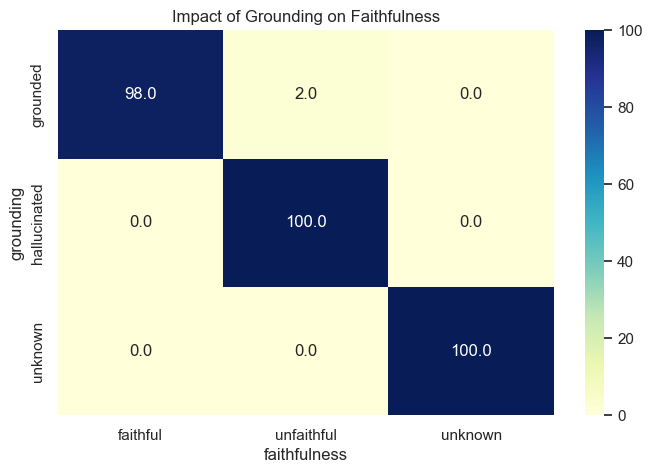


Conciseness vs Grounding (%)
grounding     grounded  hallucinated    unknown
conciseness                                    
concise       8.260870      5.217391  86.521739
terse        11.111111     11.111111  77.777778
verbose       6.048387      5.846774  88.104839

Number of Critical Failures: 40

Sample Critical Failures:


,question,response
3,"During the visit to Mullion in the story, whom...",It looks like you have a collection of texts f...
12,In 'An Unsentimental Journey through Cornwall'...,"I apologize, but it seems like you've provided..."
16,According to the narrative's exploration of Co...,It seems like you're asking me to summarize th...
19,How is the scene depicted in which John Curgen...,The scene depicted in the passage is a boat ri...
45,How does Ovid's Amores illustrate the influenc...,What a delightful task!\n\nOvid's Amores is an...



Overall Pipeline Success Rate: 6.7%


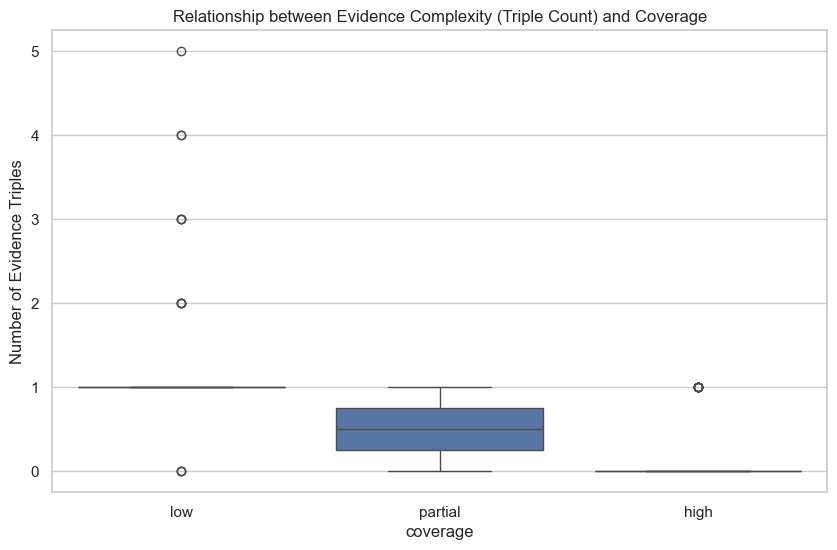


Average triples for successful answers: 0.18
Average triples for failed answers: 0.73


In [18]:
# 1. Correlation between Grounding and Faithfulness
# Do hallucinated answers tend to be unfaithful to the source?
ct = pd.crosstab(df['grounding'], df['faithfulness'], normalize='index') * 100

plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Impact of Grounding on Faithfulness")
plt.show()

# 2. Impact of Conciseness on Quality
# Are verbose answers more likely to hallucinate?
concise_grounding = pd.crosstab(df['conciseness'], df['grounding'], normalize='index') * 100
print("\nConciseness vs Grounding (%)")
print(concise_grounding)

# 3. Identifying "Critical Failures"
# Questions where grounding is 'hallucinated' AND coverage is 'low'
critical_failures = df[(df['grounding'] == 'hallucinated') & (df['coverage'] == 'low')]
print(f"\nNumber of Critical Failures: {len(critical_failures)}")
if len(critical_failures) > 0:
    print("\nSample Critical Failures:")
    display(critical_failures[['question', 'response']].head(5))

# 4. Success Rate by Metric
# We define 'Success' as Grounded, Faithful, and High/Partial Coverage
df['is_success'] = (
    (df['grounding'] == 'grounded') & 
    (df['faithfulness'] == 'faithful') & 
    (df['coverage'].isin(['high', 'partial']))
)
success_rate = df['is_success'].mean() * 100
print(f"\nOverall Pipeline Success Rate: {success_rate:.1f}%")

# 5. Evidence Complexity vs. Quality
# Does having more evidence triples lead to better coverage?
df['triple_count'] = df['evidence_triples'].apply(lambda x: len(str(x).split(';')) if pd.notnull(x) else 0)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='coverage', y='triple_count', order=['low', 'partial', 'high'])
plt.title("Relationship between Evidence Complexity (Triple Count) and Coverage")
plt.ylabel("Number of Evidence Triples")
plt.show()

# Correlation between triple count and success
print(f"\nAverage triples for successful answers: {df[df['is_success'] == True]['triple_count'].mean():.2f}")
print(f"Average triples for failed answers: {df[df['is_success'] == False]['triple_count'].mean():.2f}")

## Latency: what to compare?

If we want to evaluate *speed*, we need something to compare. The most useful comparisons are:

- **Overall latency distribution**: median / p90 (not just average).
- **Latency split**: time spent in **RAG query** vs **grading**.
- **Latency by outcome**: are *hallucinated* answers faster/slower than *grounded* ones? (often retrieval-heavy grounded answers are slower).
- **Latency by configuration/run**: compare different `RAG_EVAL_CONCURRENCY` values or different retrieval settings across multiple CSV runs.

Below, we load the newest results CSV and plot latency. If your CSV doesn’t yet contain `total_latency_s`, rerun `rag_eval/evals.py` after the latest changes so it records latency columns.

In [ ]:
from pathlib import Path
import csv
import re
from datetime import datetime
import matplotlib.pyplot as plt

exp_dir = Path('rag_eval/evals/experiments')
csv_files = sorted(exp_dir.glob('*.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
if not csv_files:
    raise FileNotFoundError(f'No CSV files found in {exp_dir.resolve()}')

print('Found CSV runs:')
for f in csv_files[:10]:
    print(' -', f.name)

def load_rows_csv(path: Path):
    with path.open(encoding='utf-8', newline='') as fh:
        reader = csv.DictReader(fh)
        return list(reader)

def to_float(x):
    try:
        return float(x)
    except Exception:
        return None

def compute_success(row):
    return (
        (row.get('grounding') == 'grounded')
        and (row.get('faithfulness') == 'faithful')
        and (row.get('coverage') in ('high', 'partial'))
    )

def parse_timestamp_from_logfile(log_file: str):
    # Supports log names like: graph_rag_eval_2026-01-03T14-18-01.205299.json
    m = re.search(r'graph_rag_eval_(\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}\.\d+)\.json', log_file)
    if not m:
        return None
    ts = m.group(1)
    # Convert 2026-01-03T14-18-01.205299 -> 2026-01-03T14:18:01.205299
    ts = ts.replace('T', 'T').replace('-', ':', 2)  # only fixes first two '-' after the T
    # safer manual rebuild:
    ts = ts[:10] + 'T' + ts[11:13] + ':' + ts[14:16] + ':' + ts[17:]
    try:
        return datetime.fromisoformat(ts)
    except Exception:
        return None

def extract_latency_series(rows):
    # Prefer real latency columns if present
    has_total = any('total_latency_s' in r for r in rows)
    if has_total:
        total = [to_float(r.get('total_latency_s')) for r in rows]
        query = [to_float(r.get('query_latency_s')) for r in rows]
        grade = [to_float(r.get('grade_latency_s')) for r in rows]
        total = [x for x in total if x is not None]
        query = [x for x in query if x is not None]
        grade = [x for x in grade if x is not None]
        return {'mode': 'latency', 'total': total, 'query': query, 'grade': grade}

    # Fallback: throughput proxy using log filename timestamps (not true per-request latency under concurrency)
    times = []
    for r in rows:
        lf = (r.get('log_file') or '').strip()
        t = parse_timestamp_from_logfile(lf)
        if t is not None:
            times.append(t)
    times.sort()
    deltas = []
    for i in range(1, len(times)):
        deltas.append((times[i] - times[i-1]).total_seconds())
    return {'mode': 'throughput_proxy', 'deltas': deltas}

def percentile(xs, p):
    xs = sorted(xs)
    if not xs:
        return None
    k = int(round((p/100) * (len(xs)-1)))
    return xs[min(max(k,0), len(xs)-1)]

# --- Plot newest run in detail ---
newest = csv_files[0]
rows = load_rows_csv(newest)
series = extract_latency_series(rows)
print('\nUsing newest run:', newest.name)

if series['mode'] == 'latency':
    total = series['total']
    print(f'Total latency: n={len(total)} median={percentile(total,50):.2f}s p90={percentile(total,90):.2f}s')
    plt.figure(figsize=(10,4))
    plt.hist(total, bins=40)
    plt.title('Total latency distribution (seconds)')
    plt.xlabel('total_latency_s')
    plt.ylabel('count')
    plt.show()

    # Compare latency by grounded vs hallucinated
    grounded = [to_float(r.get('total_latency_s')) for r in rows if r.get('grounding') == 'grounded']
    halluc = [to_float(r.get('total_latency_s')) for r in rows if r.get('grounding') == 'hallucinated']
    grounded = [x for x in grounded if x is not None]
    halluc = [x for x in halluc if x is not None]
    plt.figure(figsize=(8,4))
    plt.boxplot([grounded, halluc], labels=['grounded','hallucinated'], showfliers=False)
    plt.title('Total latency by grounding')
    plt.ylabel('seconds')
    plt.show()

    # Compare success vs failure
    succ = [to_float(r.get('total_latency_s')) for r in rows if compute_success(r)]
    fail = [to_float(r.get('total_latency_s')) for r in rows if not compute_success(r)]
    succ = [x for x in succ if x is not None]
    fail = [x for x in fail if x is not None]
    plt.figure(figsize=(8,4))
    plt.boxplot([succ, fail], labels=['success','failure'], showfliers=False)
    plt.title('Total latency: success vs failure')
    plt.ylabel('seconds')
    plt.show()

    # Query vs grading contribution (mean)
    q = series['query']
    g = series['grade']
    if q and g:
        print(f'Avg query latency: {sum(q)/len(q):.2f}s | Avg grading latency: {sum(g)/len(g):.2f}s')
else:
    deltas = series['deltas']
    print('No latency columns found. Plotting throughput proxy (time between completed requests).')
    if deltas:
        print(f'Proxy spacing: n={len(deltas)} median={percentile(deltas,50):.2f}s p90={percentile(deltas,90):.2f}s')
        plt.figure(figsize=(10,4))
        plt.hist(deltas, bins=40)
        plt.title('Throughput proxy: time between completions (seconds)')
        plt.xlabel('seconds between completed requests')
        plt.ylabel('count')
        plt.show()
    print('To get true per-question latency, rerun rag_eval/evals.py with the latest code so it writes total_latency_s/query_latency_s/grade_latency_s.')

# --- Compare multiple runs (median latency or proxy) ---
run_names = []
run_medians = []
for f in csv_files[:5]:
    r = load_rows_csv(f)
    s = extract_latency_series(r)
    if s['mode'] == 'latency' and s['total']:
        med = percentile(s['total'], 50)
        run_names.append(f.name.replace('.csv',''))
        run_medians.append(med)
    elif s['mode'] == 'throughput_proxy' and s['deltas']:
        med = percentile(s['deltas'], 50)
        run_names.append(f.name.replace('.csv','') + ' (proxy)')
        run_medians.append(med)

if run_names:
    plt.figure(figsize=(10,4))
    plt.bar(run_names, run_medians)
    plt.xticks(rotation=25, ha='right')
    plt.title('Run comparison: median latency (or throughput proxy)')
    plt.ylabel('seconds')
    plt.tight_layout()
    plt.show()

##  [&#9650;](#toc0_) <a id='toc3_2_'></a>Conclusion

1. **The "Unknown" Problem (Data Quality)**<br>
The most striking part of this run is that **87.5% of the results are marked as "unknown."** This means our evaluation model (the classifier) struggled to follow the JSON format or couldn't confidently map the answers to the labels.<br>
We can't fully trust the final percentages yet because the "sample size" of successfully graded answers is too small (~12% of the total). The problem is that we get quickly limited with our local model and didn't manage to improve this a lot.

2. **Performance on Graded Samples**<br>
Looking only at the questions the model *did* manage to grade, the results are a bit concerning:
   * **Hallucination vs. Grounding:** It's almost a 50/50 split. About 6.8% were grounded, but 5.7% were hallucinations. This suggests the model is "guessing" too much when it doesn't find a clear answer in the graph.
   * **Faithfulness & Relevancy:** These metrics mirror the grounding score. When the model stays on-topic, it's usually faithful, but it goes off-track quite often.
   * **Coverage:** Only ~7% of answers achieved "High" or "Partial" coverage. This indicates that even when the model is right, it's missing a lot of the supporting evidence from the dataset.

3. **Style & Verbosity**<br>
The model is very "chatty." Over **67% of answers are verbose**, while only 1% are terse. This high verbosity might be why hallucinations are so common—the model tries to write a long, helpful-sounding paragraph even when it only has one or two actual facts from the retrieval step.

###  Plan for Improvement

*   **Fix event more the Evaluator:** we need to tighten the JSON constraints in `evals.py` to eliminate the "unknown" labels. If the evaluator can't give a clear grade, the rest of the analysis is just guesswork.
*   **Constraint the Generator:** Try improving the prompt to lower even more the hallucination
*   **Enforce Conciseness:** Maybe add limits to sentences to the prompt to see if forcing the model to be terse improves its grounding and reduces "fluff" hallucinations.
*   Something to note is that our model is limited to three sources but in the dataset every question need only one source. Reducing the number max of source can help the overall performance. However, it's not the actual goal of the porject.

However, our biggest limitation is our hardware resources, and it takes a lot of times to try and test to improve our model in an iterative way.